## He estimation from temperature measurements-no inflation

In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
using Revise
using EnKF
using Distributions
using DocStringExtensions
using LinearAlgebra
using ProgressMeter
using DifferentialEquations

In [3]:
cd(dirname(pwd()))
cd(dirname(pwd()))
cd("src") 


include("Systems.jl")
using ..Systems

include("Tools.jl")
using ..Tools


include("Thermomodel.jl")
using ..Thermomodel

include("Postprocessing.jl")
using ..Postprocessing


## Initialization

In [4]:
    ω0 = [sqrt(1.2e004)];
    ℘ = [1.2e005];


    Θ = 0.15;
    θe = 1 + Θ;
    θc = 1 - Θ;
    
    He = 3000.0;
    Hc = 3000.0;


    γ = 1.3;#not 1.4!!!!! maybe 1.33?

In [5]:
    L = 4.0  # total length of the pipe when streched to a 1D pipe
    L2D = 2.0 # the actual length of the bended pipe in the real world
    alpha = pi/2 # inclination angle 

1.5707963267948966

In [6]:
tube = Tube(L,L2D,alpha)

Tube(4.0, 2.0, 1.5707963267948966)

In [7]:
Xe = map(tuple, [0.0; 3.0], [1.0; 4.0])
evap = Evaporator(He,θe,Xe)

Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 4.0)])

In [8]:
Xc = map(tuple, [1.0], [3.0])
cond = Condenser(Hc,θc,Xc)

Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0)])

In [9]:
X0 = [(1.5,3.5)]
dXdt0 = [(0.0,0.0)]
liquids=LiquidSlug(γ,ω0,℘,X0,dXdt0)

LiquidSlug(1.3, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(1.5, 3.5)], Tuple{Float64,Float64}[(0.0, 0.0)])

In [10]:
P = [1.0,1.0]

vapors=VaporPlug(γ,P)

VaporPlug(1.3, [1.0, 1.0])

In [11]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors)

PHPSystem(Tube(4.0, 2.0, 1.5707963267948966), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 4.0)]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0)]), LiquidSlug(1.3, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(1.5, 3.5)], Tuple{Float64,Float64}[(0.0, 0.0)]), VaporPlug(1.3, [1.0, 1.0]))

## Get numerical solution

In [12]:
Lvaporplug = XptoLvaporplug(X0,L)
M = P.^(1/γ).* Lvaporplug

u=vcat(XMtovec(sys0.liquidslug.Xp,sys0.liquidslug.dXdt,M), He...)

7-element Array{Float64,1}:
    1.5
    3.5
    0.0
    0.0
    1.5
    0.5
 3000.0

## EnKF PropagationFunction

In [13]:
function zhang2002modelEnKF!(du::Array{Float64,1},uEnKF::Array{Float64,1},p::PHPSystem,t::Float64)

    sys = p

    # added He as a state vector entry
    u = uEnKF[1:end-1]
    uHe = deepcopy(uEnKF[end])

    numofliquidslug =  Integer( (length(u) - 1)/5 )
    
    (Xp,dXdt0,M)=vectoXM(u)

    γ = sys.liquidslug.γ
    ω0 = sys.liquidslug.ω0
    ℘ = sys.liquidslug.℘
    Lvaporplug = XptoLvaporplug(Xp,sys.tube.L)
#     Lliquidslug = XptoLliquidslug(Xp)
    height = getheight(Xp,sys.tube.L2D,sys.tube.alpha)
    Xpvapor = getXpvapor(Xp,sys.tube.L)


    P = real.((M./Lvaporplug .+ 0im).^(γ))

    θ = real.((P .+ 0im).^((γ-1)/γ))


    for i = 1:numofliquidslug
        du[2*i-1] = u[2*numofliquidslug+2*i-1]
        du[2*i] = du[2*i-1]

        du[2*numofliquidslug + 2*i-1] = -32*u[2*numofliquidslug + 2*i-1] - (ω0[i]^2)*(0.5*(height[i][end]-height[i][1])) + ℘[i]*(P[i]-P[i+1])
        du[2*numofliquidslug + 2*i] = du[2*numofliquidslug + 2*i-1]

    end


        du[4*numofliquidslug+1:5*numofliquidslug+1] .= dMdtzhang2002modelEnKF(Xpvapor,θ,sys,uHe)
    
    du[end]=0.0

    return du

end


function dMdtzhang2002modelEnKF(Xpvapor::Array{Tuple{Float64,Float64},1},θ::Array{Float64,1},sys::PHPSystem,uHe)

    dMdt=zeros(length(Xpvapor))


    Xe = sys.evaporator.Xe
    He = uHe
    θe = sys.evaporator.θe

    Xc = sys.condenser.Xc
    Hc = sys.condenser.Hc
    θc = sys.condenser.θc

    Levapoverlap=XpvaportoLoverlap(Xpvapor,Xe)
    Lcondoverlap=XpvaportoLoverlap(Xpvapor,Xc)


    # May not be right for multi liquid flow
    for i = 1:length(Xpvapor)
        if Lcondoverlap[i] < 1e-8
            dMdt[i] = He * Levapoverlap[i] * (θe-θ[i])
        else
            dMdt[i] = -Hc * Lcondoverlap[i] * (θ[i]-θc)
        end
    end

    return dMdt

end

dMdtzhang2002modelEnKF (generic function with 1 method)

In [14]:
tstep=1.0e-5

p = sys0
tspan = (0.0, 0.1);
T = tspan[1]:tstep:tspan[end]

prob = ODEProblem(zhang2002modelEnKF!, u, tspan, p)
sol = solve(prob, RK4(), adaptive=false, dt=tstep);
integrator = init(prob, RK4(), adaptive =false, dt = tstep, save_everystep=false)

t: 0.0
u: 7-element Array{Float64,1}:
    1.5
    3.5
    0.0
    0.0
    1.5
    0.5
 3000.0

## EnKF

In [103]:
newHe = 10000.0

10000.0

In [104]:
function (::PropagationFunction)(t::Float64, ENS::EnsembleState{N, TS}) where {N, TS}
    for (i,s) in enumerate(ENS.S)
        
        set_t!(integrator, deepcopy(t))
        set_u!(integrator, deepcopy(s))
#         for j=1:10
        step!(integrator)
#         end
        ENS.S[i] = deepcopy(integrator.u)

    end
    
    return ENS
end

In [105]:
fprop = PropagationFunction()

PropagationFunction()

In [106]:
function (::MeasurementFunction)(t::Float64, s::TS) where TS
    result=soltoResult(s[1:end-1],sys0);
#     return [s[3]]
    return [deepcopy(result.θ[1]),deepcopy(result.θ[2])]
end

In [107]:
function (::MeasurementFunction)(t::Float64) 
#     return reshape([0.0, 0.0, 1.0, 0.0, 0.0, 0.0],(1,6))
    return reshape([1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.0,0.0],(2,7))
end

In [108]:
m = MeasurementFunction()

MeasurementFunction()

In [109]:
function (::RealMeasurementFunction)(t::Float64, ENS::EnsembleState{N, TZ}) where {N, TZ}
    let s = sol(t)
#     fill!(ENS, [deepcopy(s[3])])
        result=soltoResult(s[1:end-1],sys0);
    fill!(ENS, [deepcopy(result.θ[1]),deepcopy(result.θ[2])])
    end
    return ENS
end

In [110]:
z = RealMeasurementFunction()

RealMeasurementFunction()

In [111]:
# A = MultiAdditiveInflation(2, 1.05, MvNormal(zeros(1), 2.0*I))
A = MultiAdditiveInflation(7, 1.001, MvNormal(zeros(7), 0.0001*Diagonal([0.1,0.1,10.0,10.0,0.1,0.1,8000.0])))
# A = IdentityInflation()

MultiAdditiveInflation{7}(1.001, DiagNormal(
dim: 7
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0e-5 0.0 … 0.0 0.0; 0.0 1.0e-5 … 0.0 0.0; … ; 0.0 0.0 … 1.0e-5 0.0; 0.0 0.0 … 0.0 0.8]
)
)

In [112]:
# this is measurement noise!!!!!!!!
# ϵ = AdditiveInflation(MvNormal(zeros(1), 1.0*I))
ϵ = AdditiveInflation(MvNormal(zeros(2), Diagonal([0.01,0.01].^2)))

AdditiveInflation{2}(DiagNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [0.0001 0.0; 0.0 0.0001]
)
)

In [113]:
N = 50
# NZ = 1
NZ = 2
isinflated = false
isfiltered = false
isaugmented = true

true

In [114]:
x₀ = [1.0, 3.0, 0.0, 0.0, 1.0, 1.0, newHe]
ens = initialize(N, MvNormal(x₀, Diagonal([1.0,1.0,100.0,100.0,1.0,1.0,5000.0].^2)))
estimation_state = [deepcopy(ens.S)]

true_state = [deepcopy(x₀)]
covs = []

0-element Array{Any,1}

In [115]:
g = FilteringFunction()

FilteringFunction()

In [116]:
enkf = ENKF(N, NZ, fprop, A, g, m, z, ϵ, isinflated, isfiltered, isaugmented)

ENKF{50,2}(PropagationFunction(), MultiAdditiveInflation{7}(1.001, DiagNormal(
dim: 7
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0e-5 0.0 … 0.0 0.0; 0.0 1.0e-5 … 0.0 0.0; … ; 0.0 0.0 … 1.0e-5 0.0; 0.0 0.0 … 0.0 0.8]
)
), FilteringFunction(), MeasurementFunction(), RealMeasurementFunction(), AdditiveInflation{2}(DiagNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [0.0001 0.0; 0.0 0.0001]
)
), false, false, true)

In [117]:
Δt = 1e-5
Tsub = 0.0:Δt:0.1-Δt

for (n,t) in enumerate(Tsub)

    global ens
    
    t, ens, cov = enkf(t, Δt, ens)
    
    push!(estimation_state, deepcopy(ens.S))
    push!(covs, deepcopy(cov))
    

end

## Show the results

In [118]:
s =  hcat(sol(T).u...)
ŝ =  hcat(mean.(estimation_state)...)
# ŝ =  hcat(solEnKF(T).u...)

results=soltoResult(sol[1:end-1,:],sys0);
resultŝ=soltoResult(ŝ[1:end-1,:],sys0);
# resultŝ=soltoResult(solEnKF[1:end-1,:],sys0);



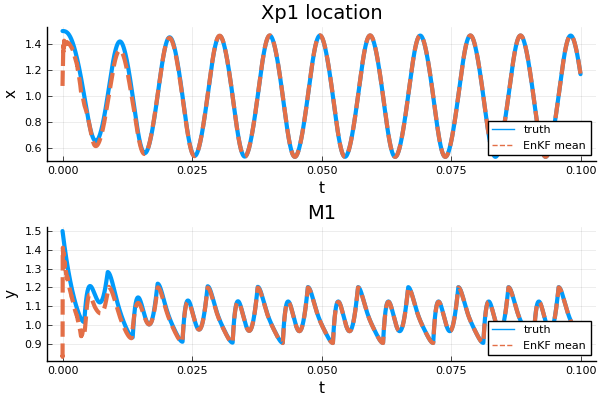

In [119]:
plt1 = plot(layout = (2, 1), legend = :bottomright)
plot!(plt1[1], T, results.Xp[1][1:end-1], linewidth = 3, label = "truth")
plot!(plt1[1], Tsub, resultŝ.Xp[1][1:end-1], linewidth = 3, markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash,title="Xp1 location")

plot!(plt1[2], T, results.M[1][1:end-1], linewidth = 3, label = "truth")
plot!(plt1[2], Tsub, resultŝ.M[1][1:end-1], linewidth = 3, markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "y", linestyle =:dash,title="M1")

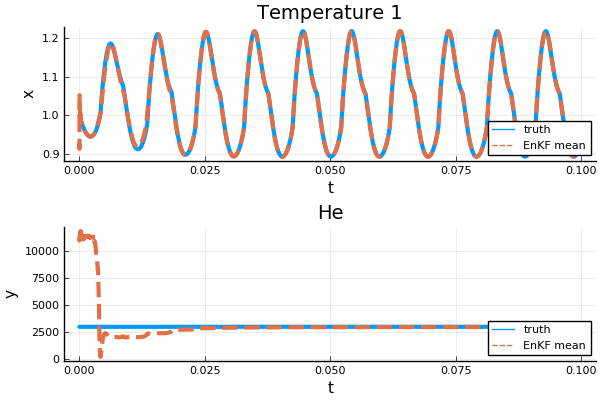

In [120]:
plt2 = plot(layout = (2, 1), legend = :bottomright)

plot!(plt2[1], T, results.θ[1][1:end-1], linewidth = 3, label = "truth")
plot!(plt2[1], Tsub, resultŝ.θ[1][1:end-1], linewidth = 3, markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash,title="Temperature 1")

plot!(plt2[2], T, [3000,3000], linewidth = 3, label = "truth")
plot!(plt2[2], Tsub, ŝ[7,1:end-1], linewidth = 3, markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "y", linestyle =:dash,title="He")

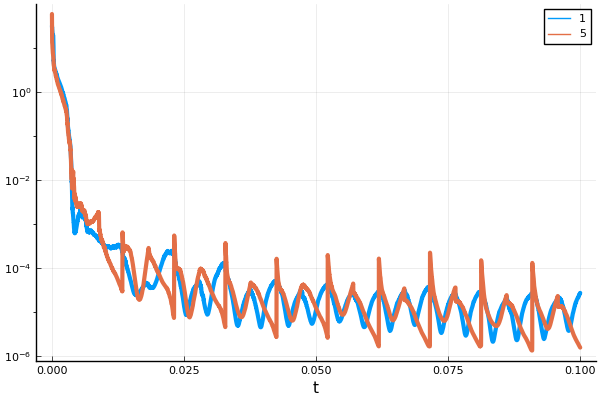

In [130]:
plot(Tsub, map(covs) do P  
        P[1,1]+ eps() end, yscale = :log10, linewidth = 3, label = "1")
plot!(Tsub, map(covs) do P
        P[5,5]+ eps() end, yscale = :log10, linewidth = 3, xlabel = "t", label = "5")

In [122]:
ens.S

50-element Array{Array{Float64,1},1}:
 [1.1705561522577663, 3.1700518824198274, -264.23550083641663, -414.91827209259003, 0.9178848398114539, 1.0602228037511947, 2995.5388227153403]
 [1.17005796727076, 3.1692350815200006, -264.6349602595041, -431.6972185115859, 0.9176484355955782, 1.0603452684181052, 2976.8972200888593]    
 [1.170085394456859, 3.1690596062922523, -264.77729712501514, -441.0746991208905, 0.9174920021049546, 1.060234985194135, 2976.831130022915]    
 [1.1713913051518965, 3.170398312690425, -264.3999141702523, -384.0683838342701, 0.9176091551158273, 1.0593802909810912, 2983.000746583773]    
 [1.170307706379524, 3.169426666742517, -264.6811469752016, -437.19660153493135, 0.9174477433452515, 1.0599295367334765, 2974.106284510886]    
 [1.1700299310847753, 3.169244611494849, -264.7287118717023, -359.4290391681984, 0.9175230506771839, 1.06006403978152, 2980.559394703995]      
 [1.170304297208021, 3.1696006814143396, -264.73063592767375, -425.310751505316, 0.917428326779934

In [123]:
ŝ[7,1:end-1]

10000-element Array{Float64,1}:
 11153.096365389723 
 11187.257187050333 
 11009.415312261086 
 11150.111084383178 
 11178.755731773332 
 11361.215891670055 
 11401.87400435037  
 11413.038320929887 
 11468.755013632654 
 11507.46933302382  
 11512.283660567795 
 11649.75397625162  
 11652.392381681919 
     ⋮              
  2979.827895006382 
  2979.8303806270346
  2979.827406565205 
  2979.8350662631965
  2979.8420984980266
  2979.8416440537403
  2979.8370359544915
  2979.851242065531 
  2979.8520638318164
  2979.8554123412505
  2979.855065419864 
  2979.8581031214217

In [124]:
[1.0,1.0,100.0,100.0,1.0,1.0,80000.0].^2

7-element Array{Float64,1}:
     1.0  
     1.0  
 10000.0  
 10000.0  
     1.0  
     1.0  
     6.4e9